In [ ]:
pip install imblearn

In [40]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter1/framingham.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
heart = pd.read_csv(file_content_stream)
heart = heart.dropna()
heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Classification on Inbalanced Data

In [41]:
## frequency table of target 
heart['TenYearCHD'].value_counts() / heart.shape[0]

0    0.847648
1    0.152352
Name: TenYearCHD, dtype: float64

In [3]:
## Defining input and target variables
X = heart[['age',  'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose']]
Y = heart['TenYearCHD']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building a random forest model 
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       620
           1       1.00      0.01      0.02       112

    accuracy                           0.85       732
   macro avg       0.92      0.50      0.47       732
weighted avg       0.87      0.85      0.78       732



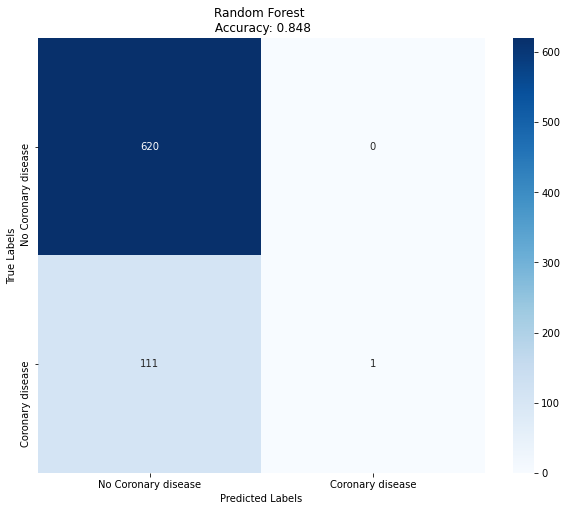

In [4]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot1.pdf')
plt.show()

## Alternate Cutoffs

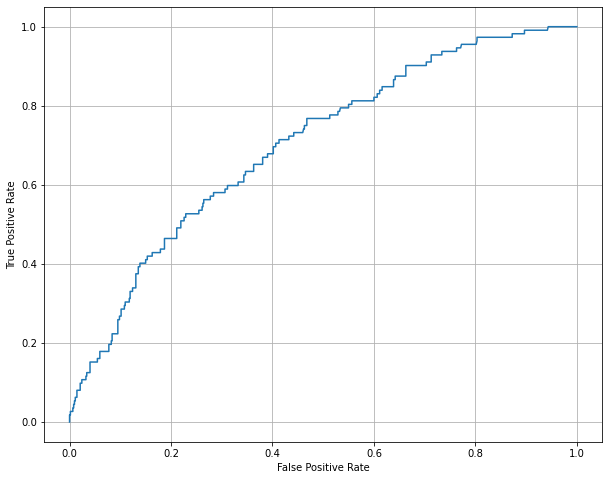

In [50]:
## Building a random forest model
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict_proba(X_test)[:, 1]

## Computing the ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, RF_pred)

## Visualizing the ROC-curve
plt.figure(figsize = (10, 8))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
# plt.savefig('chapter1_plot2.pdf')
plt.show()

## Estimating cutoff based on shortest distance to perfect model 

In [54]:
cutoff_values = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'Cutoff': thresholds})
cutoff_values['True_Positive_minus_1'] = cutoff_values['True_Positive'] - 1
cutoff_values['Distance_to_perfect_model'] = np.sqrt(cutoff_values['False_Positive']**2 + cutoff_values['True_Positive_minus_1']**2)

## Sorting based on the distance to perfect model 
cutoff_values = cutoff_values.sort_values(by = 'Distance_to_perfect_model')
cutoff_values

,False_Positive,True_Positive,Cutoff,True_Positive_minus_1,Distance_to_perfect_model
106,0.406452,0.705357,0.145875,-0.294643,0.502013
108,0.412903,0.714286,0.144271,-0.285714,0.502117
98,0.362903,0.651786,0.159347,-0.348214,0.502943
104,0.401613,0.696429,0.148129,-0.303571,0.503437
100,0.380645,0.669643,0.153787,-0.330357,0.504010
...,...,...,...,...,...
1,0.000000,0.008929,0.510780,-0.991071,0.991071
172,0.993548,1.000000,0.070550,0.000000,0.993548
173,0.996774,1.000000,0.070300,0.000000,0.996774
0,0.000000,0.000000,1.510780,-1.000000,1.000000


In [55]:
## Predicting on the test dataset (using optimal cutoff)
RF_pred = np.where(RF_pred < 0.146, 0, 1)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.92      0.60      0.72       620
           1       0.24      0.70      0.35       112

    accuracy                           0.61       732
   macro avg       0.58      0.65      0.54       732
weighted avg       0.81      0.61      0.67       732



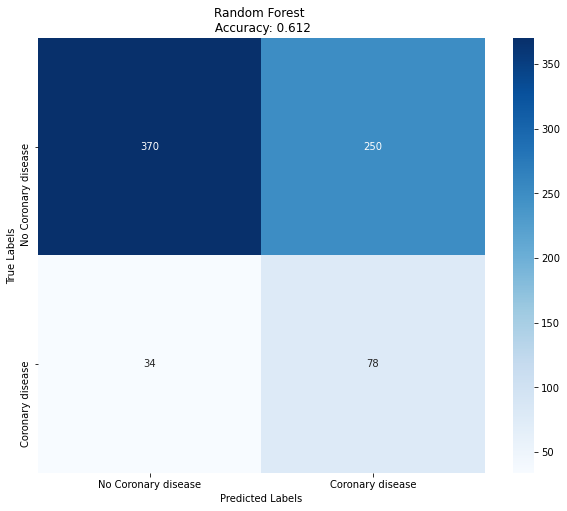

In [57]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot3.pdf')
plt.show()

## Estimating Cutoff Based on Younden's Index

In [61]:
cutoff_values = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'Cutoff': thresholds})
cutoff_values['TPR_minus_FPR'] = cutoff_values['True_Positive'] - cutoff_values['False_Positive']

## Sorting based on TPR minus FPR
cutoff_values = cutoff_values.sort_values(by = 'TPR_minus_FPR', ascending = False)
cutoff_values

,False_Positive,True_Positive,Cutoff,TPR_minus_FPR
108,0.412903,0.714286,0.144271,0.301382
118,0.467742,0.767857,0.132469,0.300115
106,0.406452,0.705357,0.145875,0.298906
82,0.264516,0.562500,0.183958,0.297984
74,0.229032,0.526786,0.190344,0.297753
...,...,...,...,...
1,0.000000,0.008929,0.510780,0.008929
172,0.993548,1.000000,0.070550,0.006452
173,0.996774,1.000000,0.070300,0.003226
0,0.000000,0.000000,1.510780,0.000000


## Dealing with Class-Imbalanced Data: Class Weights

In [65]:
## Building a random forest model (including weights)
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3, class_weight = 'balanced').fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict_proba(X_test)[:, 1]

In [66]:
## Computing the ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, RF_pred)

cutoff_values = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'Cutoff': thresholds})
cutoff_values['True_Positive_minus_1'] = cutoff_values['True_Positive'] - 1
cutoff_values['Distance_to_perfect_model'] = np.sqrt(cutoff_values['False_Positive']**2 + cutoff_values['True_Positive_minus_1']**2)

## Sorting based on the distance to perfect model 
cutoff_values = cutoff_values.sort_values(by = 'Distance_to_perfect_model')
cutoff_values

,False_Positive,True_Positive,Cutoff,True_Positive_minus_1,Distance_to_perfect_model
118,0.369355,0.678571,0.492182,-0.321429,0.489632
120,0.377419,0.687500,0.488262,-0.312500,0.490002
119,0.377419,0.678571,0.489142,-0.321429,0.495744
116,0.366129,0.660714,0.496626,-0.339286,0.499165
117,0.369355,0.660714,0.494228,-0.339286,0.501535
...,...,...,...,...,...
4,0.006452,0.044643,0.705078,-0.955357,0.955379
1,0.000000,0.008929,0.772355,-0.991071,0.991071
2,0.001613,0.008929,0.749453,-0.991071,0.991073
0,0.000000,0.000000,1.772355,-1.000000,1.000000


In [67]:
## Changing likelihoods to labels (cutoff = 0.492)
RF_pred = np.where(RF_pred < 0.492, 0, 1)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.92      0.63      0.75       620
           1       0.25      0.68      0.36       112

    accuracy                           0.64       732
   macro avg       0.58      0.65      0.56       732
weighted avg       0.81      0.64      0.69       732



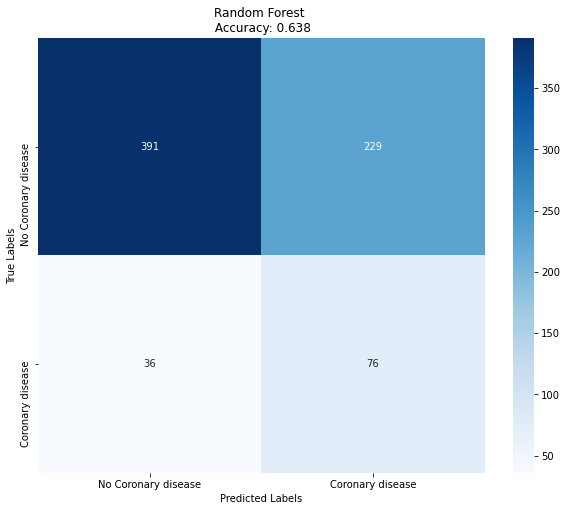

In [69]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.savefig('chapter1_plot4.pdf')
plt.show()

## Under-Sampling

In [17]:
## Running under-sampling 
X_under, Y_under = RandomUnderSampler().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_under = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_under, Y_under)

## Predicting on the test dataset
RF_pred_under = RF_under.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_under))

              precision    recall  f1-score   support

           0       0.91      0.58      0.71       620
           1       0.23      0.68      0.34       112

    accuracy                           0.60       732
   macro avg       0.57      0.63      0.53       732
weighted avg       0.81      0.60      0.65       732



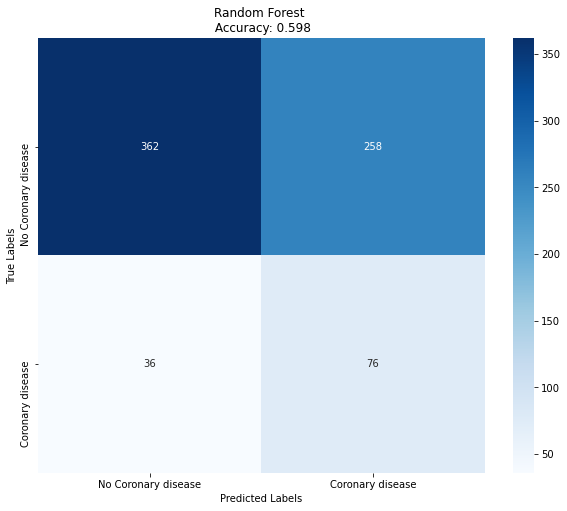

In [35]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_under)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_under)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot3.pdf')
plt.show()

## Over-Sampling

In [23]:
## Running over-sampling 
X_over, Y_over = RandomOverSampler().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_over = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_over, Y_over)

## Predicting on the test dataset
RF_pred_over = RF_over.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_over))

              precision    recall  f1-score   support

           0       0.91      0.60      0.72       620
           1       0.23      0.65      0.34       112

    accuracy                           0.61       732
   macro avg       0.57      0.63      0.53       732
weighted avg       0.80      0.61      0.67       732



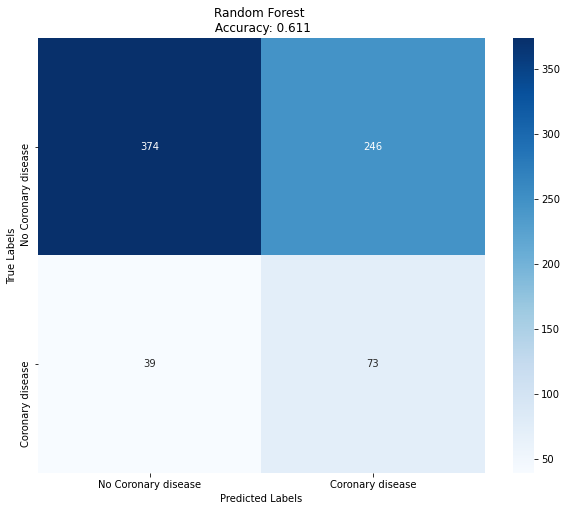

In [37]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_over)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_over)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot4.pdf')
plt.show()

## SMOTE

In [30]:
## Running SMOTE
X_smote, Y_smote = SMOTE().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_smote = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_smote, Y_smote)

## Predicting on the test dataset
RF_pred_smote = RF_over.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_smote))

              precision    recall  f1-score   support

           0       0.91      0.60      0.72       620
           1       0.23      0.65      0.34       112

    accuracy                           0.61       732
   macro avg       0.57      0.63      0.53       732
weighted avg       0.80      0.61      0.67       732



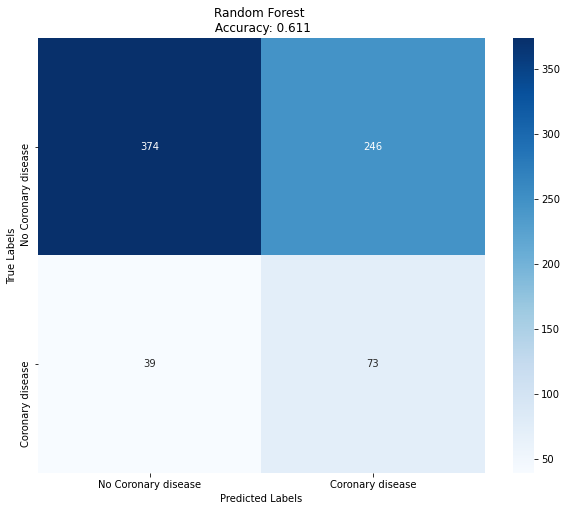

In [39]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_smote)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_smote)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot5.pdf')
plt.show()

In [ ]:
## Building a random forest model (including weights)
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3, class_weight = 'balanced').fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

In [ ]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot2.pdf')
plt.show()